I am using the Seattle Airbnb Datasets which comprises of 3 files: Calendar, Listings and Reviews.
We will be utilizing the dataset to build a model which will attempt to predict prices based on Reviews using NLP.

In [1]:
# Data exploration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

Import all 3 datasets and identify useful information that can be used for the model.

In [2]:
reviews = pd.read_csv('seattle/reviews.csv')
listings = pd.read_csv('seattle/listings.csv')
calendar = pd.read_csv('seattle/calendar.csv')

reviews.shape, listings.shape, calendar.shape

((84849, 6), (3818, 92), (1393570, 4))

Check and review structure of files

In [3]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
listings.price.head()

0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

In [6]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
# Create a dataset for unavailable listings for later use
unavailable = calendar[calendar.available == 'f']
unavailable.shape

(459028, 4)

In [8]:
# Build features for All Unique Prices
# Unavailable listings does not have prices associated, create a filter for available listings

available = calendar[calendar.available == 't']

all_prices = available.groupby('listing_id')['price'].nunique()
unique_prices =  all_prices.to_frame()
unique_prices.shape

(3723, 1)

Merge calendar data (price column) and reviews

In [9]:
# Drop columns that will not be used
reviews.drop(columns=["id", "reviewer_id", "reviewer_name", "date"], inplace=True)

In [11]:
# Clean up data on prices column
prices = available.drop(columns=['available', 'date'])
prices.drop_duplicates(subset='price', keep="first", inplace=True)
prices.head()

,listing_id,price
0,241032,$85.00
365,953595,$125.00
452,953595,$154.00
453,953595,$164.00
454,953595,$165.00


In [15]:
# Merge reviews and prices updated datasets
reviews_prices = pd.merge(reviews, prices, on="listing_id", how="outer")
reviews_prices.head(10)

,listing_id,comments,price
0,7202016,Cute and cozy place. Perfect location to every...,NaN
1,7202016,Kelly has a great room in a very central locat...,NaN
2,7202016,"Very spacious apartment, and in a great neighb...",NaN
3,7202016,Close to Seattle Center and all it has to offe...,NaN
4,7202016,Kelly was a great host and very accommodating ...,NaN
5,7202016,"Kelly was great, place was great, just what I ...",NaN
6,7202016,Kelly was great! Very nice and the neighborhoo...,NaN
7,7202016,hola all bnb erz - Just left Seattle where I h...,NaN
8,7202016,Kelly's place is conveniently located on a qui...,NaN
9,7202016,"The place was really nice, clean, and the most...",NaN


In [16]:
# Remove listings that does not contain prices and NaN values
reviews_prices.dropna(axis=0, how='any', subset={'price'}, inplace=True)
reviews_prices.head(10)

,listing_id,comments,price
2552,7207641,Joe and Anna are very friendly. They made us f...,$348.00
2553,7207641,"Listing was accurate, host even left neighborh...",$348.00
2554,7207641,Great house in a great neighborhood! Everythin...,$348.00
2555,7207641,Great house! Top notch location and appliances...,$348.00
2556,7207641,Very clean and organized. The hosts provided ...,$348.00
3415,8811781,Wonderful place!,$516.00
3416,8811781,Wonderful place!,$576.00
3417,8811781,Wonderful place!,$573.00
3418,8811781,Wonderful place!,$540.00
3419,8811781,Wonderful place!,$544.00


In [17]:
# Correct datatype for price from str to int
reviews_prices['price'] = pd.to_numeric(reviews_prices['price'].map(lambda x: x.strip('$').replace(',','')))
print("price data type: ", type(reviews_prices['price'].iloc[0]))

price data type:  <class 'numpy.float64'>


Start of NLP

In [30]:
# imports
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re

# define function tokenize

def tokenize(text):
    '''
    for text strings to be tokenized (tokens)
    removing stop words
    Lemmatization
    '''
    tokens = word_tokenize(text)
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
reviews_prices['comments'].value_counts(normalize=True)[:20]

The Plum Modern house was ideally suited for a recent trip to Seattle for a family wedding. With ten adults and two children coming in from various states, staying at Plum Modern allowed us to stay together as a family, prepare and eat meals together, and was only minutes from the wedding venue. We all took turns exploring the neighborhood and shopping at the local stores. The kids enjoyed playing with available toys and eveyone pulled books out to read on especially rainy evenings. We even got to enjoy a little time in the hot tub - such gorgeous views from the roof! We were all grateful for the opportunity to stay together at Plum Modern, and several of us discussed renting the apartment at some point in the future when we return to visit the bride and groom. :)    0.005855
This is a FANTASTIC house. We were 5 adults and two children and we had plenty of room (we rented the main house and the basement apartment). It is in fantastic condition. The kitchen is enormous and has everythin

In [32]:
# Using the function
reviews_prices['comments'] = reviews_prices['comments'].apply(str)
reviews_prices['base_tokens'] = reviews_prices['comments'].apply(tokenize)
reviews_prices['base_tokens'].head()

2552    [joe, anna, friendly, made, u, feel, well, wel...
2553    [listing, accurate, host, even, left, neighbor...
2554    [great, house, great, neighborhood, everything...
2555    [great, house, top, notch, location, appliance...
2556    [clean, organized, host, provided, clear, answ...
Name: base_tokens, dtype: object

In [34]:
reviews_prices[['comments', 'base_tokens']][:10]

,comments,base_tokens
2552,Joe and Anna are very friendly. They made us f...,"[joe, anna, friendly, made, u, feel, well, wel..."
2553,"Listing was accurate, host even left neighborh...","[listing, accurate, host, even, left, neighbor..."
2554,Great house in a great neighborhood! Everythin...,"[great, house, great, neighborhood, everything..."
2555,Great house! Top notch location and appliances...,"[great, house, top, notch, location, appliance..."
2556,Very clean and organized. The hosts provided ...,"[clean, organized, host, provided, clear, answ..."
3415,Wonderful place!,"[wonderful, place]"
3416,Wonderful place!,"[wonderful, place]"
3417,Wonderful place!,"[wonderful, place]"
3418,Wonderful place!,"[wonderful, place]"
3419,Wonderful place!,"[wonderful, place]"


Analyzing Tokens

In [37]:
# Create a function which takes a corpus of document and returns a dataframe of word counts

from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [38]:
wc = count(reviews_prices['base_tokens'])
print(wc.shape)
wc.head()

(6997, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,great,9268,13722,1.0,0.020656,0.020656,0.526860
47,stay,8223,11325,2.0,0.017047,0.037703,0.467455
81,place,6624,9072,3.0,0.013656,0.051359,0.376556
116,seattle,6941,8850,4.0,0.013322,0.064681,0.394577
117,apartment,4628,7246,5.0,0.010907,0.075588,0.263089


Visualizing with Comment Clouds

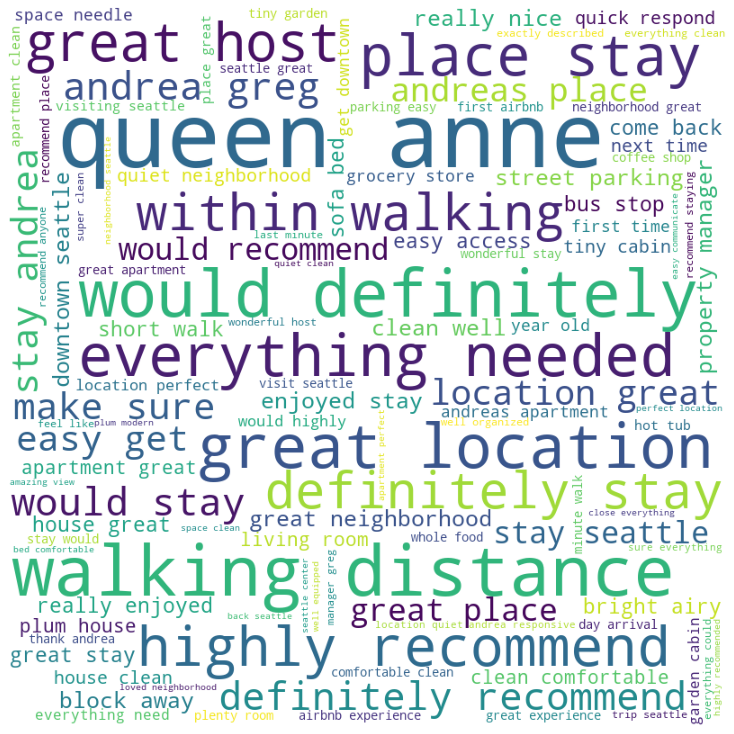

In [41]:
from wordcloud import WordCloud

comment_words = ''
stop_words = set(stopwords.words('english'))

for val in reviews_prices.base_tokens:
    val = str(val)
    tokens = word_tokenize(val)
    tokens = re.sub('[^a-zA-Z 0-9]', '', val)
    tokens = tokens.lower().split()
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                     background_color='white',
                     stopwords = stop_words,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Price Prediction Model based on Reviews

In [42]:
# initialize pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor())
])

# split data and remove NA values
reviews_prices.dropna(inplace=True)
X = reviews_prices['comments']
y = reviews_prices['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline fit
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_dec

In [43]:
y_preds = pipeline.predict(X_test)
y_preds

array([ 46.43511111, 106.5844136 , 240.53437799, ...,  79.28296978,
       183.05857138, 508.54449487])

In [44]:
mse = mean_squared_error(y_test, y_preds)
mse

8666.316947590838

In [45]:
from math import sqrt

rmse = sqrt(mse)
rmse

93.09305531343806

In [46]:
y_test.head(10)

59417     43.0
43954    102.0
50280    236.0
41057     62.0
95055    177.0
95183    199.0
41266     55.0
38162     56.0
41912     53.0
53391    281.0
Name: price, dtype: float64

In [47]:
r2 = r2_score(y_test, y_preds)
r2

0.802996543380233

In [48]:
mae = mean_absolute_error(y_test, y_preds)
mae

48.01319183623751

The RMSE resulted to >90 which makes a poor performance for this model